<a href="https://colab.research.google.com/github/ramazanengcmpr/githubsode1/blob/master/ProjeGen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
# set up environment
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
import seaborn as sb
import time

In [ ]:
# a function for preparing our training and testing data
def prep_data(phenotype) :
    pheno = pd.read_csv(r'/content/drive/My Drive/PROJEGEN/Archive/MEDA/metadata.csv', index_col=0)
    pheno = pheno.dropna(subset=[phenotype]) # drop samples that don't have a value for our chosen resistance profile
    pheno = pheno[phenotype]

    # read in unitig data
    X = pd.read_csv('/content/drive/My Drive/PROJEGEN/Archive/FILT/' + phenotype + '_gwas_filtered_unitigs.Rtab', sep=" ", index_col=0, low_memory=False)
    X = X.transpose()
    X = X[X.index.isin(pheno.index)] # only keep rows with a resistance measure
    pheno = pheno[pheno.index.isin(X.index)]
    return X, pheno

In [ ]:
# prepare our data for predicting antibiotic resistance
phenotype = 'azm_sr'

X, pheno = prep_data(phenotype)

# create an array for storing performance metrics
performance = []
method = []
times = []

In [ ]:
# take a look at the data

print(pheno.shape)
print(pheno)

print(X.shape)
print(X.iloc[:10,:10])

(3478,)
Sample_ID
ERR1549286    1.0
ERR1549290    1.0
ERR1549291    1.0
ERR1549287    1.0
ERR1549288    1.0
             ... 
ERR2172350    1.0
ERR2172351    1.0
ERR2172352    1.0
ERR2172353    1.0
ERR2172354    0.0
Name: azm_sr, Length: 3478, dtype: float64
(3478, 515)
pattern_id  CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG  \
ERR1549286                                                0   
ERR1549290                                                0   
ERR1549291                                                0   
ERR1549287                                                0   
ERR1549288                                                0   
ERR1549299                                                0   
ERR1549292                                                0   
ERR1549298                                                0   
ERR1549296                                                0   
ERR1549300                                                0   

pattern_id  TACCGTAACCGGCAATGCGGATA

Index(['CTTAACATATTTGCCTTTGATTTTTGAAGAAGCTGCCACGCCGGCAG',
       'TACCGTAACCGGCAATGCGGATATTACGGTC', 'CAGACGGCATTTTTTTTGCGTTTTTCGGGAGG',
       'AACGGGTTTTCAGACGGCATTCGATATCGGGACG',
       'CCAAAAATTACCCGCGTTGACGTAGCTAAAGA',
       'CGGACCGGTATTCCGTCGAAATCACCGCCGTCAACCGCCCC',
       'TGAAATTGTCCATCTCGTATGCCGTCTTCTGCTTG',
       'TACGGTATTGTCCGCATTATTAAACTCAAAACC,AGAAGACGGCATACGAGATGGACAATTTCATCC',
       'GGCATTTTTTTTGCGTTTTTCGGGAGGGGGCGGC',
       'TATATAAGGGGTTGCCGTTCCGCAGTTGGGCGGCAGCATAC'],
      dtype='object', name='pattern_id')


<ipython-input-10-0936fa84a933>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(uni_len)


<Axes: ylabel='Density'>

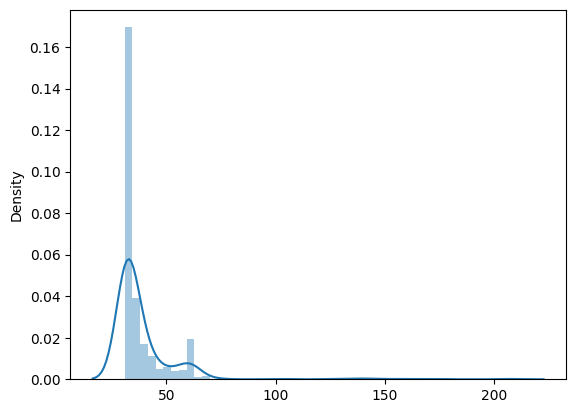

In [ ]:
# look at the length distribution of the unitigs in our dataset
unitigs = X.columns
print(unitigs[:10])
mylen = np.vectorize(len)
uni_len = mylen(unitigs)
sb.distplot(uni_len)

In [ ]:
# function for fitting a model
def fitmodel(X, pheno, estimator, parameters, modelname, method, performance, times) :

    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()

        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]

        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)

        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)

        # call all samples with a predicted value less than or equal to 0.5 as sensitive to the antibiotic,
        # and samples with predicted value >0.5 resistant to the antibiotic
        y_pred[y_pred<=0.5] = 0
        y_pred[y_pred>0.5] = 1

        score = balanced_accuracy_score(y_test, y_pred)
        performance = np.append(performance, score)
        method = np.append(method, modelname)
        times = np.append(times, (time.process_time() - start))

        print("Best hyperparameters for this fold")
        print(gs_clf.best_params_)
        print("Confusion matrix for this fold")
        print(confusion_matrix(y_test, y_pred))
    return gs_clf, method, performance, times

In [ ]:
def sbplot(X, pheno, estimator, parameters, modelname, method, performance, times) :
    results = []

    kfold = KFold(n_splits=5)
    for train_index, test_index in kfold.split(X, pheno):
        # time how long it takes to train each model type
        start = time.process_time()

        # split data into train/test sets
        X_train = X.iloc[train_index]
        y_train = pheno[train_index]
        X_test = X.iloc[test_index]
        y_test = pheno[test_index]

        # perform grid search to identify best hyper-parameters
        gs_clf = GridSearchCV(estimator=estimator, param_grid=parameters, cv=3, n_jobs=-1, scoring='balanced_accuracy')
        gs_clf.fit(X_train, y_train)

        # predict resistance in test set
        y_pred = gs_clf.predict(X_test)

        results.append([y_test, y_pred])

    return results

In [ ]:
enet = SGDClassifier(loss="log", penalty="elasticnet")
enet_params = {
    'l1_ratio': [0.1, 0.2, 0.5]
}

enet_model, method, performance, times = fitmodel(X, pheno, enet, enet_params, "Elastic net", method, performance, times)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[531  19]
 [ 31 115]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[685   3]
 [  0   8]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[646   3]
 [ 10  37]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best hyperparameters for this fold
{'l1_ratio': 0.1}
Confusion matrix for this fold
[[589  36]
 [ 13  57]]


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Best hyperparameters for this fold
{'l1_ratio': 0.2}
Confusion matrix for this fold
[[481  38]
 [ 10 166]]


In [ ]:
svm = SVC(class_weight='balanced')
svm_params = {
    'C': [0.01],
    'gamma': [1e-06, 1e-05],
    'kernel': ['linear']
}

svm_model, method, performance, times = fitmodel(X, pheno, svm, svm_params, "Support vector machine", method, performance, times)

Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[687   1]
 [  0   8]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[638  11]
 [  2  45]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'C': 0.01, 'gamma': 1e-06, 'kernel': 'linear'}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


In [ ]:
xgb_mod = xgb.XGBClassifier(random_state=0)
xgb_params = {
    'alpha': [1e-5, 1e-4],
    'colsample_bytree': [0.6],
    'gamma': [0.05, 0.1],
    'learning_rate': [0.01, 0.1],
    'max_depth': [2],
    'objective': ['binary:hinge'],
    'subsample': [0.2, 0.4, 0.6]
}

xgb_model, method, performance, times = fitmodel(X, pheno, xgb_mod, xgb_params, "XGBoost", method, performance, times)

Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.6}
Confusion matrix for this fold
[[535  15]
 [ 15 131]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[686   2]
 [  0   8]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.2}
Confusion matrix for this fold
[[636  13]
 [  2  45]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 0.6, 'gamma': 0.05, 'learning_rate': 0.01, 'max_depth': 2, 'objective': 'binary:hinge', 'subsample': 0.6}
Confusion matrix for this fold
[[590  35]
 [  5  65]]
Best hyperparameters for this fold
{'alpha': 1e-05, 'colsample_bytree': 

In [ ]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1, class_weight="balanced")
rf_params = {
    'max_features': [round(X.shape[1]*0.1), round(X.shape[1]*0.5), round(X.shape[1]*0.8)],
    'max_depth': [3],
    'n_estimators': [50]
}

rf_model, method, performance, times = fitmodel(X, pheno, rf, rf_params, "Random forest", method, performance, times)

Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 412, 'n_estimators': 50}
Confusion matrix for this fold
[[538  12]
 [ 15 131]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[681   7]
 [  0   8]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[637  12]
 [  2  45]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[588  37]
 [  5  65]]
Best hyperparameters for this fold
{'max_depth': 3, 'max_features': 258, 'n_estimators': 50}
Confusion matrix for this fold
[[505  14]
 [  6 170]]


<ipython-input-17-4b587a44c781>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10)


([0, 1, 2, 3],
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

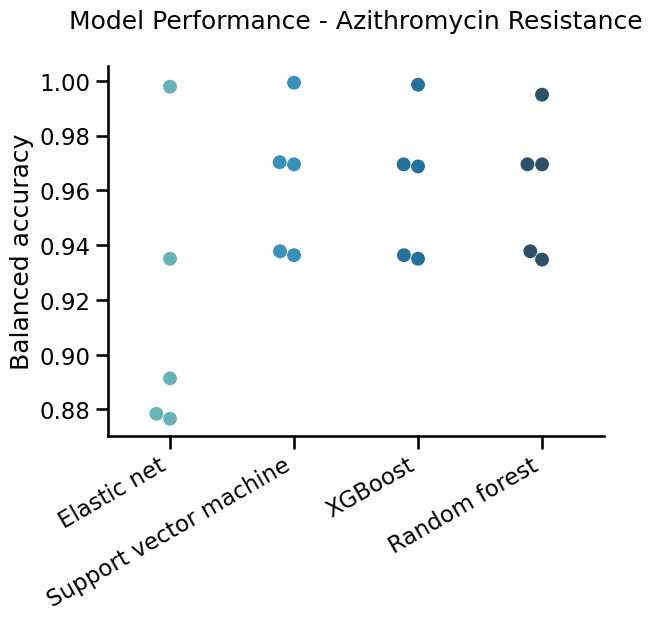

In [ ]:
# compare results from the different predictors
sb.set_context("talk")
plt.title("Model Performance - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=performance, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Balanced accuracy")
plt.xticks(rotation=30, ha='right')

<ipython-input-18-02f2e1501ead>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)


([0, 1, 2, 3],
 [Text(0, 0, 'Elastic net'),
  Text(1, 0, 'Support vector machine'),
  Text(2, 0, 'XGBoost'),
  Text(3, 0, 'Random forest')])

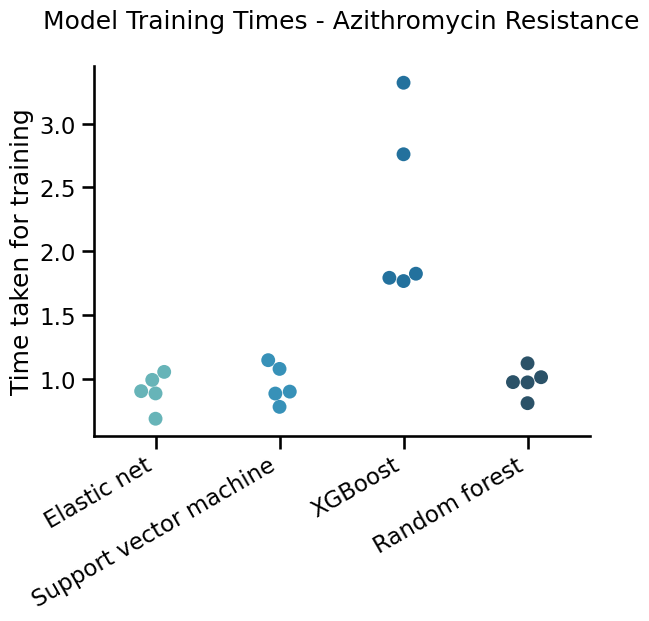

In [ ]:
# took at the time taken to train the different models
sb.set_context("talk")
plt.title("Model Training Times - Azithromycin Resistance", y=1.08)
sb.swarmplot(x=method, y=times, palette="YlGnBu_d", size=10)
sb.despine()
plt.ylabel("Time taken for training")
plt.xticks(rotation=30, ha='right')

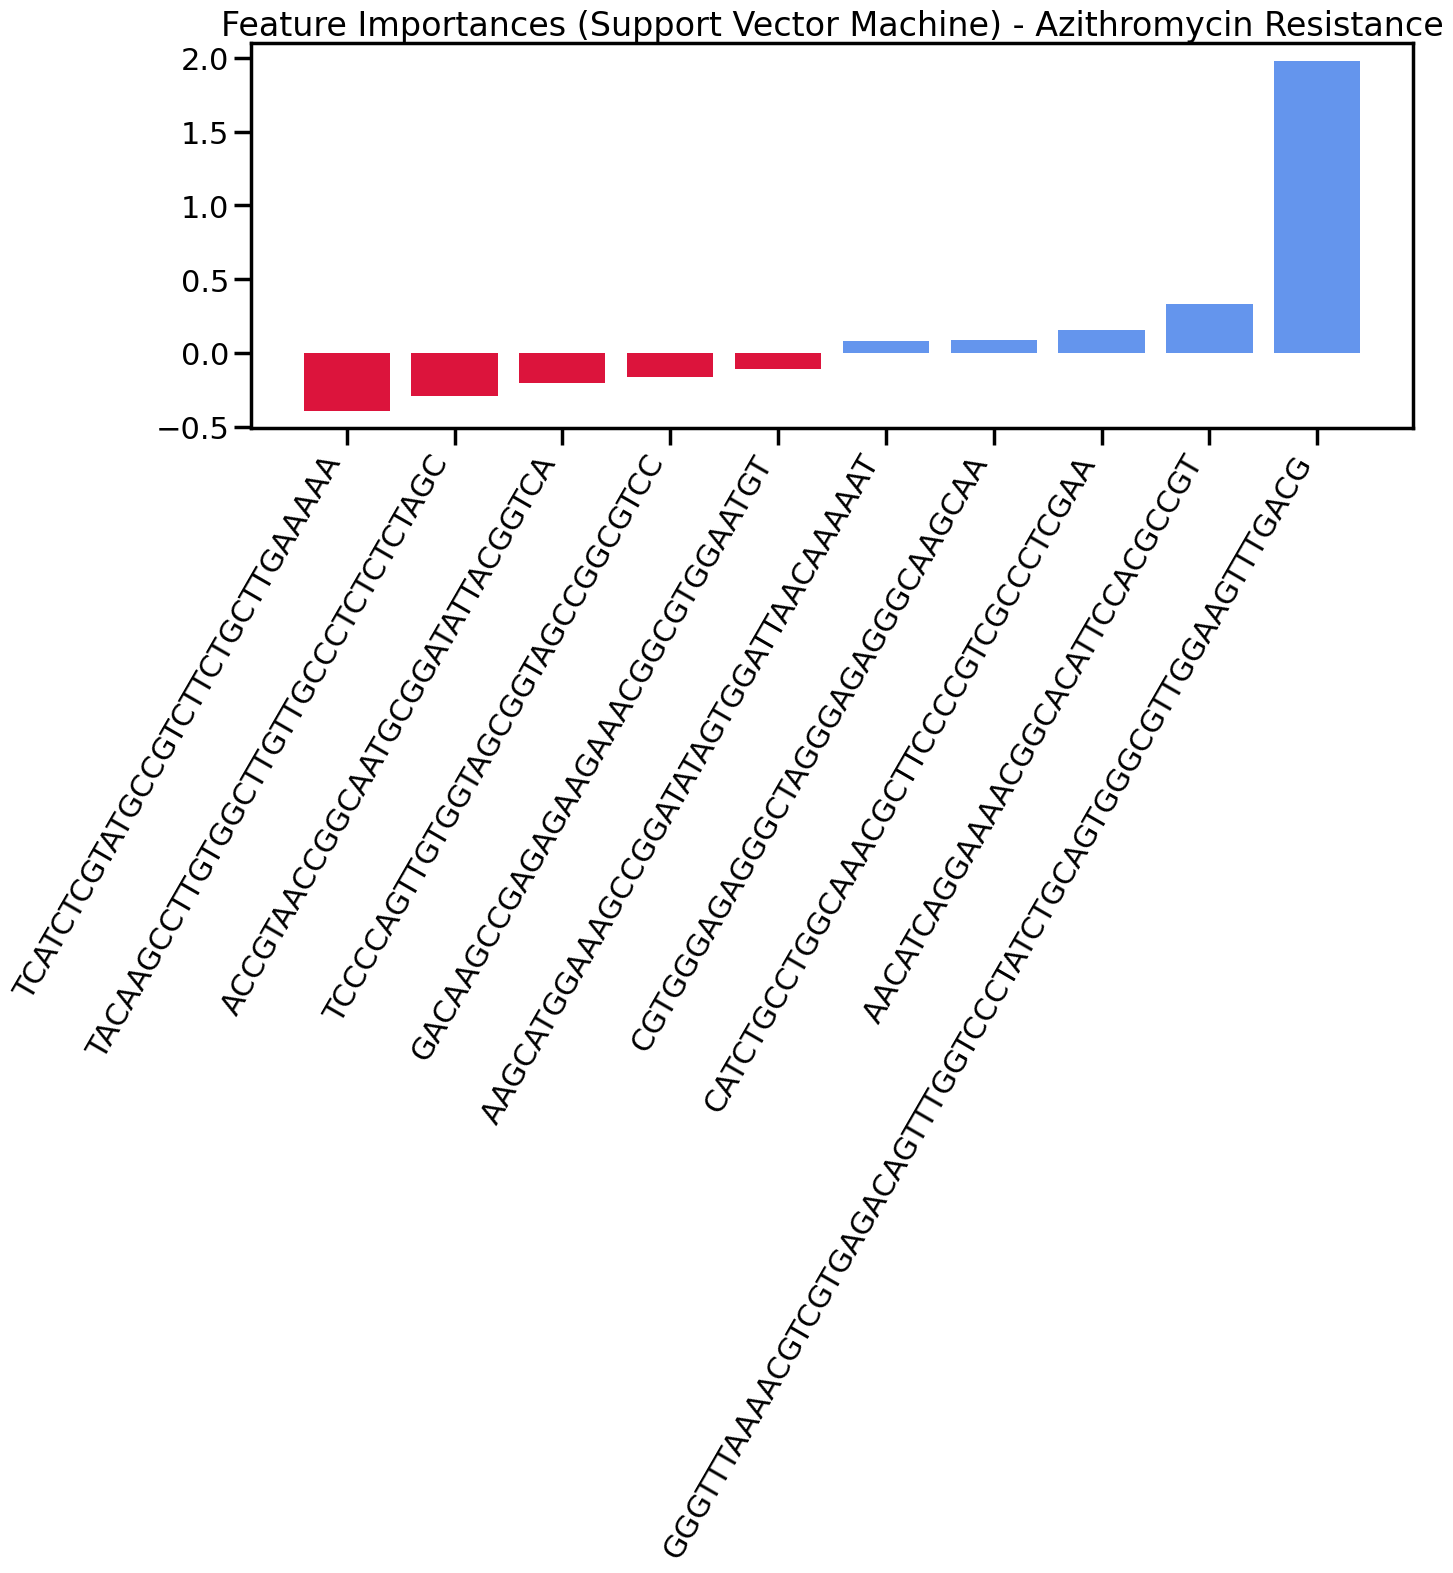

Top negative predictors:  ['TCATCTCGTATGCCGTCTTCTGCTTGAAAAA' 'TACAAGCCTTGTGGCTTGTTGCCCTCTCTCTAGC'
 'ACCGTAACCGGCAATGCGGATATTACGGTCA' 'TCCCCAGTTGTGGTAGCGGTAGCCGGCGTCC'
 'GACAAGCCGAGAGAAGAAACGGCGTGGAATGT']
Top positive predictors:  ['AAGCATGGAAAGCCGGATATAGTGGATTAACAAAAAT' 'CGTGGGAGAGGGCTAGGGAGAGGGCAAGCAA'
 'CATCTGCCTGGCAAACGCTTCCCCGTCGCCCTCGAA' 'AACATCAGGAAAACGGCACATTCCACGCCGT'
 'GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG']


In [ ]:
# function for looking at SVM feature importance
def plot_coefficients(classifier, feature_names, top_features=5):
    coef = classifier.best_estimator_.coef_.ravel()
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    sb.set_context("poster")
    plt.figure(figsize=(15, 5))
    plt.title("Feature Importances (Support Vector Machine) - Azithromycin Resistance")
    colors = ['crimson' if c < 0 else 'cornflowerblue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    np.asarray(feature_names)[top_positive_coefficients]

plot_coefficients(svm_model, list(X.columns))

# if we print the unitigs, we can then look at what genes they relate to
coef = svm_model.best_estimator_.coef_.ravel()
feature_names = list(X.columns)
top_negative_coefficients = np.argsort(coef)[:5]
print("Top negative predictors: ", np.asarray(feature_names)[top_negative_coefficients])

top_positive_coefficients = np.argsort(coef)[-5:]
print("Top positive predictors: ", np.asarray(feature_names)[top_positive_coefficients])

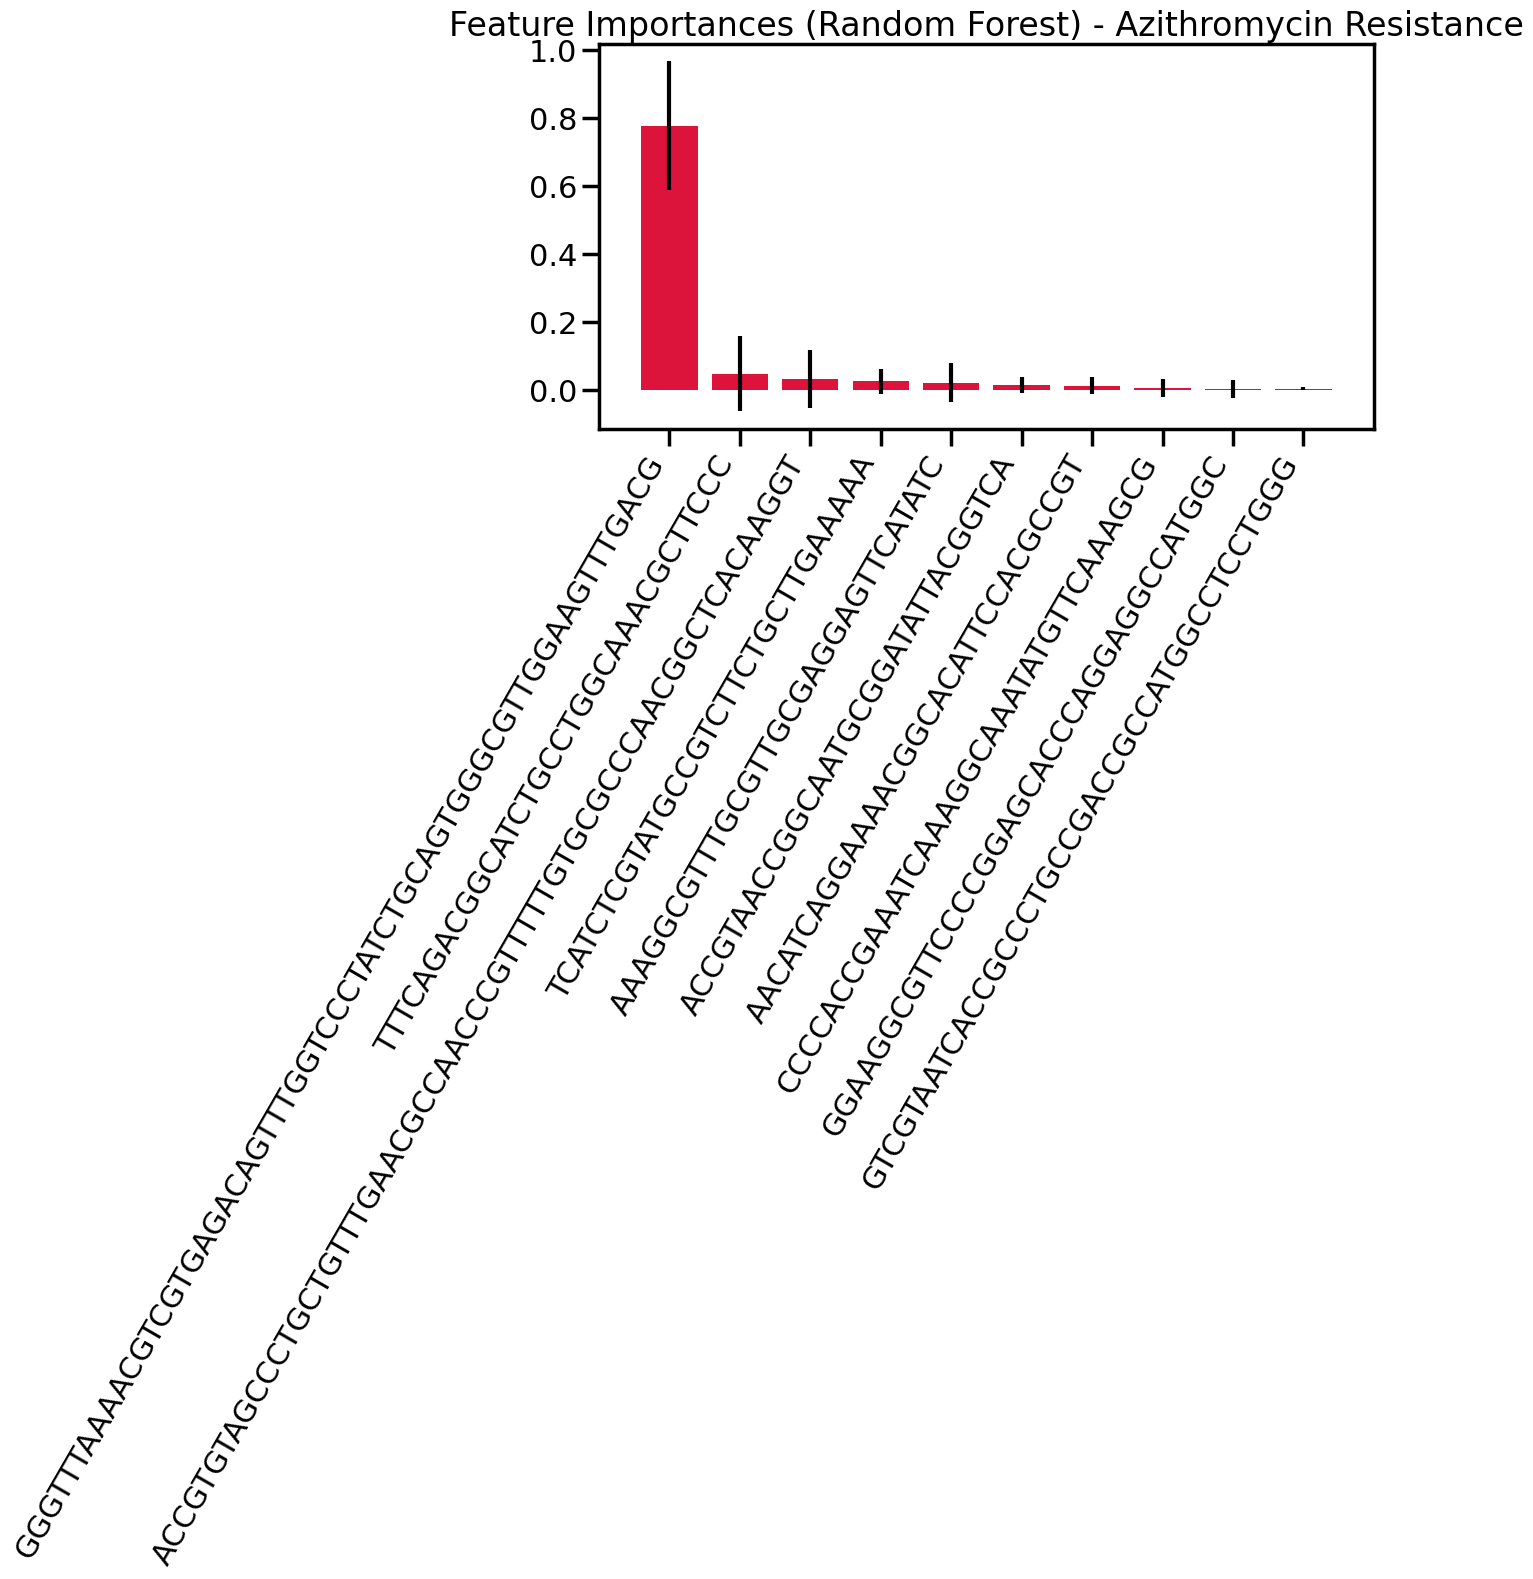

Top predictors:  ['GGGTTTAAAACGTCGTGAGACAGTTTGGTCCCTATCTGCAGTGGGCGTTGGAAGTTTGACG'
 'TTTCAGACGGCATCTGCCTGGCAAACGCTTCCC'
 'ACCGTGTAGCCCTGCTGTTTGAACGCCAACCCGTTTTTGTGCGCCCAACGGCTCACAAGGT'
 'TCATCTCGTATGCCGTCTTCTGCTTGAAAAA' 'AAAGGCGTTTGCGTTGCGAGGAGTTCATATC'
 'ACCGTAACCGGCAATGCGGATATTACGGTCA' 'AACATCAGGAAAACGGCACATTCCACGCCGT'
 'CCCCACCGAAATCAAAGGCAAATATGTTCAAAGCG'
 'GGAAGGCGTTCCCCGGAGCACCCAGGAGGCCATGGC'
 'GTCGTAATCACCGCCCTGCCGACCGCCATGGCCTCCTGGG']


In [ ]:
importances = rf_model.best_estimator_.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.best_estimator_.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1][:10]

# Plot the feature importances of the forest
sb.set_context("poster")
plt.figure(figsize=(10, 5))
plt.title("Feature Importances (Random Forest) - Azithromycin Resistance")
plt.bar(range(10), importances[indices],
       color="crimson", yerr=std[indices], align="center")
plt.xticks(range(10), np.asarray(feature_names)[indices], rotation=60, ha='right')
plt.xlim([-1, 10])
plt.show()

feature_names = list(X.columns)
print("Top predictors: ", np.asarray(feature_names)[indices])

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    sb.set_context("talk")
    plt.figure(figsize=(7, 5))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Balanced accuracy")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="balanced_accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid(color='gainsboro')

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="crimson")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="cornflowerblue")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="crimson",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="cornflowerblue",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

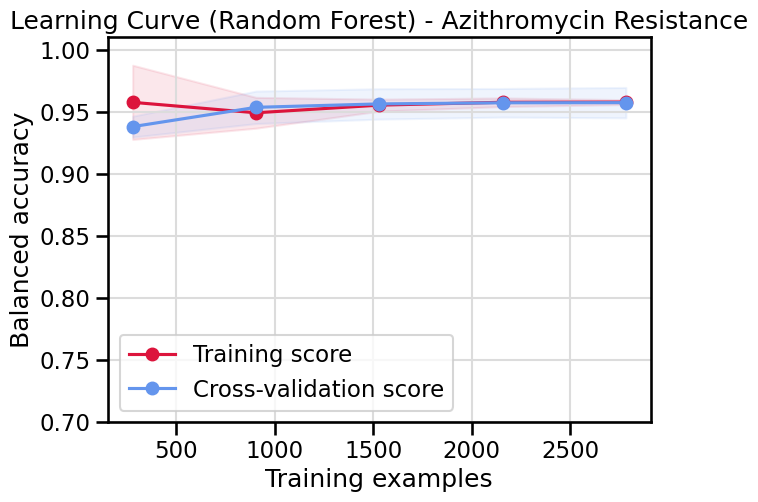

In [ ]:
title = "Learning Curve (Random Forest) - Azithromycin Resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = RandomForestClassifier(max_features=round(X.shape[1]*0.5), n_jobs=-1, max_depth=3, n_estimators=50)
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()

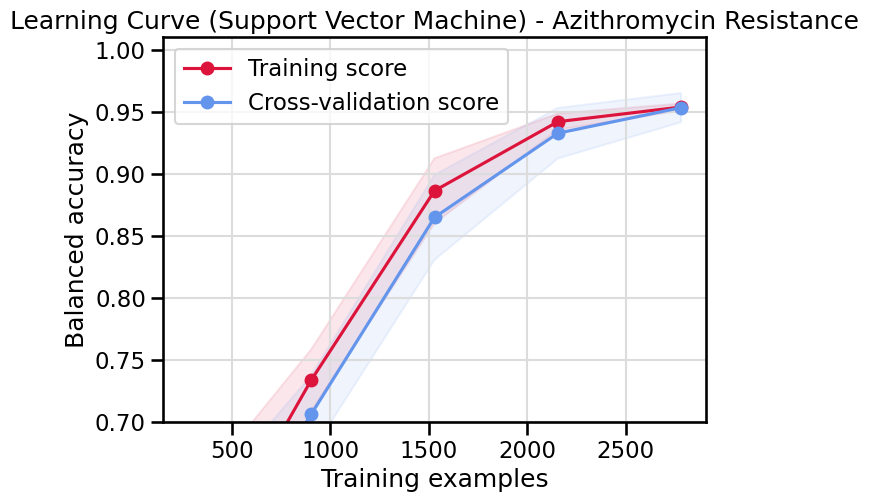

In [ ]:
title = "Learning Curve (Support Vector Machine) - Azithromycin Resistance"
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)

estimator = SVC(C=0.01, gamma=1e-06, kernel='linear')
plot_learning_curve(estimator, title, X, pheno, ylim=(0.7, 1.01), cv=cv, n_jobs=-1)

plt.show()